Imports

In [20]:
import os
import glob
import numpy as np
import geemap
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

raw_dir = "../data/raw"
processed_dir = "../data/processed"
os.makedirs(processed_dir, exist_ok=True)

Helper Functions

In [10]:
def read_raster(path):
    with rasterio.open(path) as src:
        return src.read(1), src.transform, src.crs, src.profile

def resample_to_match(src_path, reference_profile):
    with rasterio.open(src_path) as src:
        data = src.read(
            out_shape=(
                src.count,
                reference_profile["height"],
                reference_profile["width"],
            ),
            resampling=Resampling.bilinear,
        )[0]

        return data

Cloud/Outlier Mask

In [11]:
def remove_outliers(array, low=-1.0, high=1.0):
    arr = np.copy(array)
    arr[arr < low] = low
    arr[arr > high] = high
    return arr

Convert MODIS BurnDate to label mask

In [12]:
def burned_mask(burned_array):
    mask = (burned_array > 0).astype(np.uint8)
    return mask

Main Preprocessing Pipeline

In [18]:
fires = sorted(os.listdir(raw_dir))

for fire in fires:
    print(f"Processing fire: {fire}")
    
    fire_raw_path = os.path.join(raw_dir, fire)
    fire_processed_path = os.path.join(processed_dir, fire)
    os.makedirs(fire_processed_path, exist_ok=True)
    
    # Load burned area
    burned_path = os.path.join(fire_raw_path, f"modis_burned_area.tif")
    burned_arr, burned_transform, burned_crs, burned_profile = read_raster(burned_path)
    
    base_profile = burned_profile.copy()
    base_profile.update(count=7)
    height, width = burned_arr.shape
    
    # Load and resample all input rasters
    def load_or_resample(dataset_name):
        path = os.path.join(fire_raw_path, f"{dataset_name}.tif")
        arr, _, _, profile = read_raster(path)

        if arr.shape != (height, width):
            arr = resample_to_match(path, burned_profile)
        return arr
    
    ndvi   = load_or_resample("ndvi")
    nbr    = load_or_resample("nbr")
    land   = load_or_resample("esa_landcover")
    era5   = load_or_resample("era5_mean_temp")
    chirps = load_or_resample("chirps_precip")
    srtm   = load_or_resample("srtm_dem")
    
    # Clean NDVI and NBR
    ndvi   = remove_outliers(ndvi, -1, 1)
    nbr    = remove_outliers(nbr, -1, 1)
    
    # Build feature stack
    feature_stack = np.stack([
        ndvi,
        nbr,
        land,
        era5,
        chirps,
        srtm,
        burned_arr
    ], axis=0)
    
    # Labels
    labels = burned_mask(burned_arr)
    
    # Write output rasters
    feature_path = os.path.join(fire_processed_path, f"features.tif")
    label_path = os.path.join(fire_processed_path, f"labels.tif")
    
    # Save features
    with rasterio.open(
        feature_path,
        "w",
        **base_profile
    ) as dst:
        dst.write(feature_stack)
        
    # Save labels
    label_profile = burned_profile.copy()
    label_profile.update(count=1, dtype="uint8", nodata=255)
    
    with rasterio.open(
        label_path,
        "w",
        **label_profile
    ) as dst:
        dst.write(labels, 1)
        
    print(f"Saved processed data for fire: {fire}")

Processing fire: bootleg_fire
Saved processed data for fire: bootleg_fire
Processing fire: caldor_fire
Saved processed data for fire: caldor_fire
Processing fire: camp_fire
Saved processed data for fire: camp_fire
Processing fire: carr_fire
Saved processed data for fire: carr_fire
Processing fire: dixie_fire
Saved processed data for fire: dixie_fire
Processing fire: east_troublesome_fire
Saved processed data for fire: east_troublesome_fire
Processing fire: glass_fire
Saved processed data for fire: glass_fire
Processing fire: thomas_fire
Saved processed data for fire: thomas_fire


View select rasters

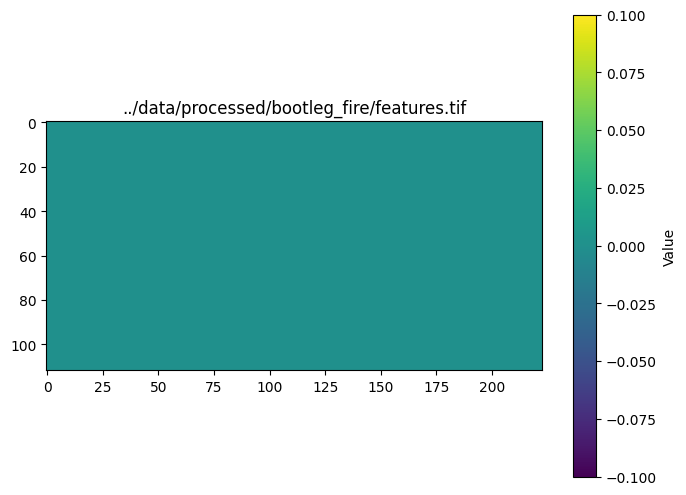

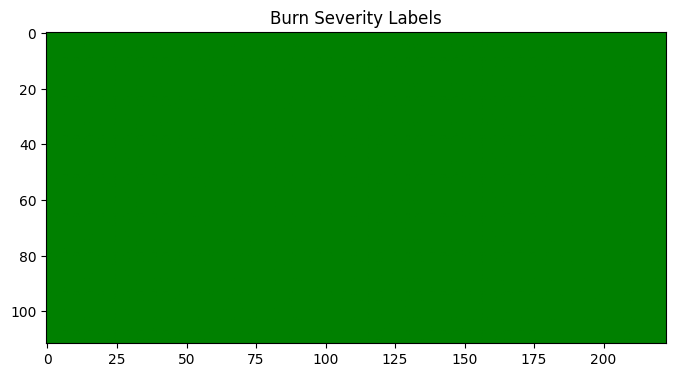

Output()

Output()

In [22]:
feature_tif_path = "../data/processed/bootleg_fire/features.tif"

with rasterio.open(feature_tif_path) as src:
    img = src.read(1)

plt.figure(figsize=(8,6))
plt.imshow(img, cmap="viridis")
plt.colorbar(label="Value")
plt.title(feature_tif_path)
plt.show()

cmap = ListedColormap([
    "green",      # 0 unburned
    "yellow",     # 1 low
    "orange",     # 2 moderate
    "red",        # 3 high
    "black"       # 255 nodata
])

label_tif_path = "../data/processed/bootleg_fire/labels.tif"
with rasterio.open(label_tif_path) as src:
    labels = src.read(1)

plt.figure(figsize=(8,6))
plt.imshow(labels, cmap=cmap, vmin=0, vmax=255)
plt.title("Burn Severity Labels")
plt.show()

geemap.show_image(feature_tif_path)
geemap.show_image(label_tif_path)